# EE4375-2022: Extension of Sixth Lab Session: Quadrature for First Order Lagrange Elements
Extension of 2D FEM using second order elements and quadrature. 

## Import Packages

In [21]:
import Gmsh: gmsh 
using GR 
using LinearAlgebra
using FastGaussQuadrature
using Plots
using SparseArrays
using BenchmarkTools

In [22]:
include("quadrature.jl")

compute_weights_triangle

## Section 1/: Introduction

## Section 2/: Geometry and Mesh Generation of Unit Square Geometry

In [23]:
#..1/4: initialize gmsh 
gmsh.initialize()

#..2/4: generate geometry 
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("square")
#..set mesh density parameter 
lc = .1
#..define four points via (x,y,z) coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
#..define four edges by connecting point labels pairwise  
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
#..define curved loop by connecting four edge labels  
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
#..define surface by curved loop 
gmsh.model.geo.addPlaneSurface([1], 1)
#..give label to the surface 
#..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
gmsh.model.setPhysicalName(2, 1, "My surface")
#..synchronize model 
gmsh.model.geo.synchronize()

#..3/4: generate two-dimensional mesh 
gmsh.model.mesh.generate(2)
#..if true, write mesh to file for further processing 
if (true) gmsh.write("square.msh") end 
#..if true, visualize mesh through the GUI 
if (false) gmsh.fltk.run() end 

#..4/4: finalize gmsh 
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00331767s, CPU 0.00044s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00673587s, CPU 0.003334s)
Info    : 142 nodes 286 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'


In [25]:
#..1/6: Finalize gmsh
gmsh.initialize()

#..2/6: Read mesh from file
gmsh.open("square-2nd.msh")

#..3/6: perform loop over the 1D elemements and construct I_bnd  
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

#..4/6: initialize vector of boundaryv indices (to be editted to avoid allocations withoi)
bnd_node_ids = Vector{Int64}([])

#..5/6: retrieve number of triangular elements on the 2D surface and their connectivity
for element_id in 1:nelements

    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println(" ")

    union!(bnd_node_ids,node1_id, node2_id)
    
end 

#..6/6: Finalize gmsh
gmsh.finalize()

display(bnd_node_ids)

Info    : Reading 'square-2nd.msh'...
Info    : 9 entities
Info    : 525 nodes
Info    : 286 elements
Info    : Done reading 'square-2nd.msh'
on element 1 node-1 has global number 1
on element 1 node-2 has global number 5
 


on element 2 node-1 has global number 14
on element 2 node-2 has global number 5
 
on element 3 node-1 has global number 6
on element 3 node-2 has global number 15
 
on element 4 node-1 has global number 6
on element 4 node-2 has global number 7
 
on element 5 node-1 has global number 16
on element 5 node-2 has global number 7
 
on element 6 node-1 has global number 8
on element 6 node-2 has global number 17
 
on element 7 node-1 has global number 8
on element 7 node-2 has global number 9
 
on element 8 node-1 has global number 18
on element 8 node-2 has global number 9
 
on element 9 node-1 has global number 10
on element 9 node-2 has global number 19
 
on element 10 node-1 has global number 10
on element 10 node-2 has global number 11
 
on element 11 node-1 has global number 20
on element 11 node-2 has global number 11
 
on element 12 node-1 has global number 12
on element 12 node-2 has global number 21
 
on element 13 node-1 has global number 12
on element 13 node-2 has global numbe

54-element Vector{Int64}:
  1
  5
 14
  6
 15
  7
 16
  8
 17
  9
 18
 10
 19
  ⋮
 52
 44
 53
 45
 54
 46
 55
 47
 56
 48
 57
 49

## Section 4:/ FEM Computation 

In [26]:
function area_triangle(x1,x2,x3,y1,y2,y3)
    x12 = x2 - x1; x13 = x3-x1;
    y12 = y2 - y1; y13 = y3-y1;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2
    return area_id 
end

area_triangle (generic function with 1 method)

In [27]:
# polynomial degree to FE approximation  
pdegree = 1;
# degree of numerical quadrature 
qorder = 6; 
xi = compute_coordinates_triangle(qorder)
w  = compute_weights_triangle(qorder)
display(xi)
display(w)

16-element Vector{Vector{Float64}}:
 [0.06943184420297371, 0.06461106321354769]
 [0.06943184420297371, 0.30709631153115907]
 [0.06943184420297371, 0.6234718442658671]
 [0.06943184420297371, 0.8659570925834785]
 [0.33000947820757187, 0.046518677526560935]
 [0.33000947820757187, 0.22110322250073802]
 [0.33000947820757187, 0.44888729929169013]
 [0.33000947820757187, 0.6234718442658671]
 [0.6699905217924281, 0.02291316667641278]
 [0.6699905217924281, 0.10890625570683385]
 [0.6699905217924281, 0.22110322250073802]
 [0.6699905217924281, 0.30709631153115907]
 [0.9305681557970262, 0.004820780989426014]
 [0.9305681557970262, 0.02291316667641278]
 [0.9305681557970262, 0.046518677526560935]
 [0.9305681557970262, 0.06461106321354769]

16-element Vector{Float64}:
 0.02815038307692565
 0.0527752773542295
 0.0527752773542295
 0.02815038307692565
 0.03799714764795021
 0.0712356204997401
 0.0712356204997401
 0.03799714764795021
 0.018715815315012756
 0.0350877052529335
 0.0350877052529335
 0.018715815315012756
 0.0021003652444748482
 0.003937685608733464
 0.003937685608733464
 0.0021003652444748482

Info    : Reading 'square.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square.msh'


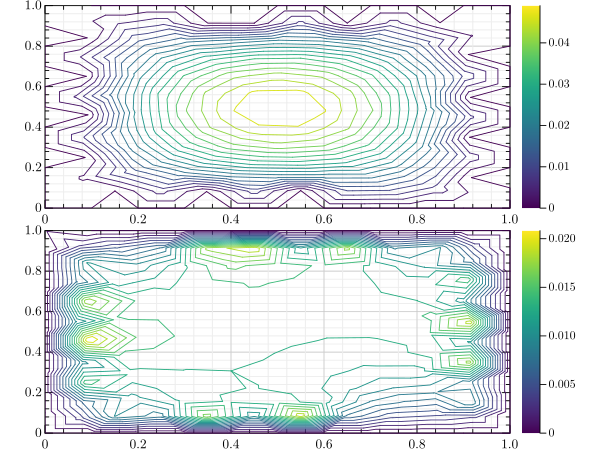

In [28]:
#..1/12: Finalize gmsh
gmsh.initialize()

#..2/12: Generate the mesh
gmsh.open("square.msh")

#..3/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Define the source function and analytical reference solution 
sourcefunction(x)  = 4*x[1]*(1-x[1])+4*x[2]*(1-x[2])
analreffunction(x) = x[1]*(1-x[1])*x[2]*(1-x[2])

#..6/12 Initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  I = Vector{Int64}([node1_id; node2_id; node3_id])
  # display(I)
    
  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
  x1 = [xnode1, ynode1]; x2 = [xnode2, ynode2]; x3 = [xnode3, ynode3];  

  #....compute surface area of the current element
  area_id = area_triangle(xnode1,xnode2,xnode3,ynode1,ynode2,ynode3)

  #....computation of the coefficients of the basis functions 
  x = [x1, x2, x3]
  X = [[x1[1], x1[2], 1] for x1 in x]
  X = reduce(vcat,transpose(X))
  Emat = X\UniformScaling(1.)
   
  #....transform quadrature points to physical domain    
  T = zeros(2,2); T[:,1] = x2 - x1; T[:,2] = x3 - x1; 
  xs = [T*xi1+x1 for xi1 in xi];

  #....construct Vandermonde Matrix for evaluation of the basis functions
  Xs = zeros(length(w),3);   
  Xs = [[xs1[1], xs1[2], 1] for xs1 in xs];
  Xs = reduce(vcat,transpose(Xs))
    
  #....construct Vandermonde Matrix for evaluation of the x/y derivatives of basis functions
  dxXs = zeros(length(w),3);
  dxXs = [[1, 0, 0] for xs1 in xs];
  dxXs = reduce(vcat,transpose(dxXs))
  dyXs = zeros(length(w),3);
  dyXs = [[0, 1, 0] for xs1 in xs];
  dyXs = reduce(vcat,transpose(dyXs))

  #....coonstruct column matrices of basis functions and derivatives of the basis functions   
  Phi   = Xs*Emat; 
  dxPhi = dxXs*Emat; 
  dyPhi = dyXs*Emat; 

  #....compute contributions to the local mass and stiffness matrix   
  PhiPhi = zeros(length(w),9);
  [PhiPhi[:,(j-1)*3+i] = Phi[:,i].*Phi[:,j] for i=1:3,j=1:3];
  dxPhidxPhi = zeros(length(w),9);
  [dxPhidxPhi[:,(j-1)*3+i] = dxPhi[:,i].*dxPhi[:,j] for i=1:3,j=1:3];
  dyPhidyPhi = zeros(length(w),9);
  [dyPhidyPhi[:,(j-1)*3+i] = dyPhi[:,i].*dyPhi[:,j] for i=1:3,j=1:3];
  dPhidPhi = dxPhidxPhi + dyPhidyPhi; 
  Mloc = 2*area_id*Transpose(w)*PhiPhi
  Mloc = reshape(Mloc,3,3)   
  Aloc = 2*area_id*Transpose(w)*dPhidPhi
  Aloc = reshape(Aloc,3,3)  
    
  #....compute local vector contribution floc 
  fvaluesloc = sourcefunction.(xs) 
  fvaluesloc = repeat(fvaluesloc,outer=(1,3))
  floc = area_id*Transpose(w)*(fvaluesloc.*Phi)  
  floc = Transpose(floc)
    
  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  f[I] += floc
  A[I,I] += Aloc
  M[I,I] += Mloc

end

#..8/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..9/12 Make A sparse and M diagonal 
A = sparse(A)
M = Diagonal(M)

#..10/12 Compute the numerical solution
u = A\f

#..10/12: Finalize gmsh
gmsh.finalize()

uref = analreffunction.([ [xnode[i],ynode[i]] for i=1:length(xnode)])

#..11/12 Plot the numerical solution
GR.trisurf(xnode,ynode,u)

GR.subplot(2,1,1)
p1 = GR.tricont(xnode,ynode,u)
GR.subplot(2,1,2)
p1 = GR.tricont(xnode,ynode,abs.(u-uref))  